In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = "C:/Users/Camer/OneDrive/desktop/College/Digital Tools/DigitalTools_project/research_project/src/data/"

In [4]:
BTC = pd.read_csv(path + "BTC-USD.csv")
BTC['Date'] = pd.to_datetime(BTC['Date'], format='%Y/%m/%d')
BTC = BTC.set_index('Date',drop=True)

Get daily range for data

In [5]:
BTC['Range'] = BTC.High - BTC.Low

Functions to get all the data before and after a particular date.
Ensure the data is in correct format - date and index.

In [29]:
def before(data,date,period):
    ind = data.index.get_loc(date)
    
    start = max(0,ind-period)
    
    return(data.iloc[start:ind])

def after(data,date,period):
    ind = data.index.get_loc(date)
    
    end = min(len(BTC),ind+period+1)
    
    return(data.iloc[ind:end]) #include the info on the date given

Moving Average

In [6]:
def MA(data,colname,period):
    data['MA_'+str(period)] = 0
    for ind in range(period-1,len(data)):
        start = ind - period + 1
        end = ind
        
        data['MA_'+str(period)].iloc[ind] = np.mean(data[colname].iloc[start:end])
    return

C:\Users\Camer\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


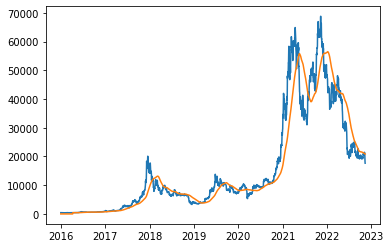

In [7]:
MA(BTC,'High',100)

plt.plot(BTC.High)
plt.plot(BTC.MA_100)

Rolling Volatiltity - idea is to look for spikes aruond the dates of interest

In [8]:
def Roll_Var(data,colname,period):
    data['Var_'+str(period)] = 0
    for ind in range(period-1,len(data)):
        start = ind - period + 1
        end = ind
        
        data['Var_'+str(period)].iloc[ind] = np.var(data[colname].iloc[start:end])
    return

C:\Users\Camer\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


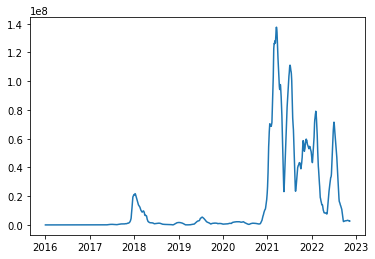

In [9]:
Roll_Var(BTC,'Adj Close',100)

plt.plot(BTC.Var_100)

Load in FED data and get the dates where the FED rate changes

In [6]:
FED = pd.read_csv(path + "FED_rate.csv")
FED['DATE'] = pd.to_datetime(FED['DATE'], format='%d/%m/%Y')
FED = FED.set_index('DATE',drop=True)

In [7]:
dates_change = []
values_change=[]

crate = FED.IOER[1]

for i in range(1,len(FED)):
    nrate = FED.IOER[i]
    
    if nrate != crate:
        dates_change.append(FED.index[i])
        values_change.append(nrate-crate)
    
    crate = nrate
    
    
dates_star = pd.DataFrame({"Dates":dates_change,"Change":values_change})

In [8]:
dates_star

,Dates,Change
0,2016-12-15,0.25
1,2017-03-16,0.25
2,2017-06-15,0.25
3,2017-12-14,0.25
4,2018-03-22,0.25
5,2018-06-14,0.20
6,2018-09-27,0.25
7,2018-12-20,0.20
8,2019-05-02,-0.05
9,2019-08-01,-0.25


Now, we want to look at the changes in BTC around these dates. We will check if there is correlation between these changes and the n-day change in BTC. I will check for n=1,2,3,...,7.

In [124]:
CHG_DATES = dates_star.Dates

CHANGE = pd.DataFrame(index=CHG_DATES,columns=['FED_change','0day','1day','2day','3day','4day','5day','6day','7day'])

for d in CHG_DATES:
    btc0 = float(before(BTC['Adj Close'],d,1)) #close day before change
    
    btc1 = after(BTC['Adj Close'],d,7) #closes on each day after the change
    btc1 = btc1.to_numpy()
    
    CHANGE.loc[d,['0day','1day','2day','3day','4day','5day','6day','7day']] = btc1 - btc0
    
    
CHANGE['FED_change'] = list(dates_star.Change)

for col in CHANGE.columns:
    CHANGE[col] = pd.to_numeric(CHANGE[col])

In [130]:
CHANGE.corr()

,FED_change,0day,1day,2day,3day,4day,5day,6day,7day
FED_change,1.000000,-0.121775,-0.071150,-0.137565,-0.220316,-0.156568,-0.197437,-0.272994,-0.241836
0day,-0.121775,1.000000,0.839905,0.800050,0.801722,0.741039,0.724519,0.763272,0.729151
1day,-0.071150,0.839905,1.000000,0.960274,0.940703,0.925157,0.875687,0.783426,0.757515
2day,-0.137565,0.800050,0.960274,1.000000,0.935841,0.865569,0.812844,0.719470,0.676462
3day,-0.220316,0.801722,0.940703,0.935841,1.000000,0.960578,0.908720,0.826185,0.801751
4day,-0.156568,0.741039,0.925157,0.865569,0.960578,1.000000,0.965985,0.874655,0.851037
5day,-0.197437,0.724519,0.875687,0.812844,0.908720,0.965985,1.000000,0.956686,0.939305
6day,-0.272994,0.763272,0.783426,0.719470,0.826185,0.874655,0.956686,1.000000,0.975990
7day,-0.241836,0.729151,0.757515,0.676462,0.801751,0.851037,0.939305,0.975990,1.000000
